In [ ]:
# All necessary libraries for this project

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Mounting/linking my Google Drive account with this Google Colab project.

from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

path = "/content/drive/My Drive/Essex Summer School 2025/3N Deep Learning for Text and Vision/Exam/"
os.chdir(path)
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/My Drive/Essex Summer School 2025/3N Deep Learning for Text and Vision/Exam


Retrieving and filtering the Fashion-MNIST data.

In [ ]:
# Retrieving and filtering the Fashion-MNIST data.

# Cnverting each image (which is a PIL image or numpy array) into a PyTorch tensor.
transform_images = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Downloading the Fashion-MNIST image dataset, and transforming all images intented for training and testing.
full_training_set = datasets.FashionMNIST(root = "./Vision_data", train = True, download = True, transform = transform_images)
full_test_set = datasets.FashionMNIST(root = "./Vision_data", train = False, download = True, transform = transform_images)

fashion_categories = full_training_set.classes
print("\nFashion categories to choose from:\n", fashion_categories)

# Choosing three classes I like and dislike for the sentiment analysis.
positive_categories = [3, 4, 5]  # dress, coat, sandal
negative_categories = [1, 6, 9]  # trouser, shirt, ankle boot

class_map = {1: 0, 6: 0, 9: 0, 3: 1, 4: 1, 5: 1}


def filter_and_relabel(dataset: Dataset) -> Dataset:
  """
    Creating a new dataset by selecting only the images from the chosen fashion categories,
    and remapping their labels into a binary format.
  """
  data = []
  targets = []
  for img, label in dataset:
      if label in class_map:
          data.append(img)
          targets.append(class_map[label])
  # Stack into tensors
  data_tensor = torch.stack(data)
  targets_tensor = torch.tensor(targets)
  return torch.utils.data.TensorDataset(data_tensor, targets_tensor)


training_subset = filter_and_relabel(full_training_set)
test_subset = filter_and_relabel(full_test_set)

# Loading batches of X images at a time for training (random order), and testing (not shuffled).
training_loader = DataLoader(training_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=1000, shuffle=False)


# Verifying whether the final dataset is balanced or skewed.
print("\nTrain label counts:", torch.bincount(training_subset.tensors[1]))
print("\nTest label counts:", torch.bincount(test_subset.tensors[1]))



Fashion categories to choose from:
 ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Train label counts: tensor([18000, 18000])

Test label counts: tensor([3000, 3000])


Building and training my custom CNN model for sentiment classification on the Fashion-MNIST data.

* My model uses two convolutional layers to firstly capture edges and then textures - I could potentially increase the conv layers to capture more details / complex visual features from the clothing images, but my machine can't handle this much processing.
* I increased the amount of filters in the second conv layer to 32 from 16, so the CNN model can learn more complex details.
* Since max pooling layers reduce spatial dimensions it can help with efficiency in learning the most important aspects (no need to focus on other details).
* Dropout helps prevent overfitting.
* Then the flattened output is passed through two fully connected layers to predict binary sentiment labels (positive vs negative) by mapping the extracted features to binary sentiment labels.
* I used ReLU activations to introduce non-linearity in learning, and the Adam optimiser with cross-entropy loss.

In [ ]:
# Building and training my custom CNN model.

class custom_CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25) # To reduce overfitting.

        # Using a dummy input to calculate the flattened size after conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            dummy_out = self._forward_features(dummy_input)
            flattened_size = dummy_out.view(-1).shape[0]

        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 2) # 2 binary categories for my model.

    def _forward_features(self, x):
        x = F.relu(self.conv1(x))   #
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        self.feature_map = x            # I need them for Grad-CAM
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


model = custom_CNN_model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training the model through batches of images, over just 3 full cycles (epochs), otherwise
# my machine can't handle it.
for epoch in range(3):
    model.train()
    for batch_idx, (data, target) in enumerate(training_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target) # Calculating the loss / how wrong the predicitons are.
        loss.backward() # Calculating the gradients.
        optimizer.step() # and updating my model's weights.
    print(f"Epoch {epoch + 1} done")


Epoch 1 done
Epoch 2 done
Epoch 3 done


Evaluating the model.

In [ ]:

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu())
        all_labels.extend(labels.cpu())

# Printing final evaluation results from the classification report.
report = classification_report(all_labels, all_preds, target_names=["negative", "positive"], output_dict = True)
print("Accuracy:", report["accuracy"])
print("F1-score (macro):", report["macro avg"]["f1-score"])
print("The current results show that the sentiment analysis model achieved an accuracy of 96% and a macro-averaged F1-score of 96% on the Fashion-MNIST test set.")



Accuracy: 0.9578333333333333
F1-score (macro): 0.9578318984465444
The current results show that the sentiment analysis model achieved an accuracy of 96% and a macro-averaged F1-score of 96% on the Fashion-MNIST test set.


I'm using Grad-CAM visualisation to highlight where the CNN is paying attention to when it makes a decision.

* To visualize what the model focuses on, I applied Grad-CAM to one of the test images, to highlight important regions in the image that influenced the model's prediction.
* The resulting heatmap confirms that the model attends to meaningful features such as the shape and structure of the clothing (i.e., the silhouette of the ankle boot in this instance). Seems to heavily focus on potentially areas that appear quite different, higher distinguishable factor between other shoes, hence seems to be focusing more on the height and back of the ankle boot?

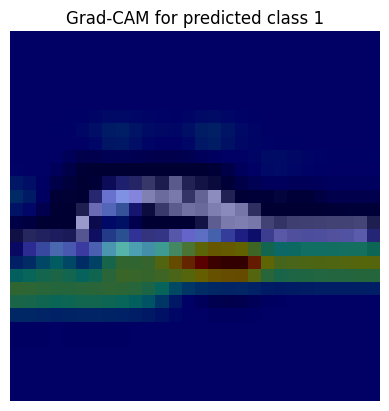

The model has correctly predicted a negative sentiment of zero for the 'ankle boot' clothing image, matching it's earlier accuracy and F1 scores.


In [ ]:
# Using Grad-CAM visualisation to highlight where the CNN is paying attention to when it makes a decision.

# Hook to capture gradients and activations
gradients = []

def save_gradient(grad):
    gradients.append(grad)


sample_img, label = next(iter(test_loader))
sample_img = sample_img[0].unsqueeze(0).to(device)  # pick first image (ankle boot, negative), 7 is the sandal (positive).
label = label[0].item() # 0 for negative, 1 for positive.

# Forward pass stage
# Here's where I'm actually passing the chosen image through my CNN network to classify it either as positive or negative,
# and checking which sentiment class it has assigned to it.
model.zero_grad()
output = model(sample_img)
pred_class = output.argmax(dim = 1).item()

model.feature_map.register_hook(save_gradient)

# Backward pass for predicted class, to check which details/pixels actually mattered in its classification.
class_score = output[0, pred_class]
class_score.backward()


# Shape: [C, H, W] - Channels, Height, Width.
grads_val = gradients[0][0].cpu().numpy()
feature_map = model.feature_map[0].detach().cpu().numpy()

# Identifying the importance of each feature map channel, and
# combining them into a 2D heatmap through Grad-CAM vectorisation, to show the areas
# my model focused its attention on
weights = np.mean(grads_val, axis=(1, 2))
cam = np.sum(weights[:, None, None] * feature_map, axis=0)

# Finally, getting the image back to its original size
cam = np.maximum(cam, 0)
cam = cam / cam.max()
cam = Image.fromarray(np.uint8(255 * cam)).resize((28, 28), Image.Resampling.BICUBIC)
cam = np.array(cam)

# ...and plotting the heatmap on top of original image
plt.imshow(sample_img.cpu().squeeze(), cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.4)  # Overlay heatmap
plt.title(f"Grad-CAM for predicted class {pred_class}")
plt.axis('off')
plt.show()


print ("The model has correctly predicted a negative sentiment of zero for the 'ankle boot' clothing image, matching it's earlier accuracy and F1 scores.")